In [1]:
import numpy as np
import random
import math
import copy
import pprint as pp
from PIL import Image

# If still humans in the place where zombies are, this will move inspite humans in cell?
# Averages, should we calculate humans or average humans in order to do the killings?
# Starting Zombie population is an average?

# Note: Rize pop 94 800 inhabitants

In [2]:
img_dir = "./img/"
pop_img_grid = Image.open(img_dir + 'pop_grid.bmp')
elv_img_grid = Image.open(img_dir + 'elev_grid.bmp')
vld_img_grid = Image.open(img_dir + 'valid_space.bmp')
pop_img_grid_arr = np.array(pop_img_grid)
elv_img_grid_arr = np.array(elv_img_grid)
vld_img_grid_arr = np.array(vld_img_grid)
z_loc = (140, 295) # (x, y)
brest = (87, 44)
rize_p = 94800 # math.ceil(94800 / 225) ? => because we divide it as cells average

In [3]:
points = [(232,141),
          (232,140),
          (232,139),
          (223,143),
          (218,144),
          (217,144),
          (199,9),
          (197,8)
         ]

for i,j in points:
    vld_img_grid_arr[j][i] = 0

In [4]:
points_1 = [(200,i) for i in range(9,131)]
points_2 = [(i,130) for i in range(200,221)]

for i,j in points_1:
    vld_img_grid_arr[j][i] = 0
for i,j in points_2:
    vld_img_grid_arr[j][i] = 0

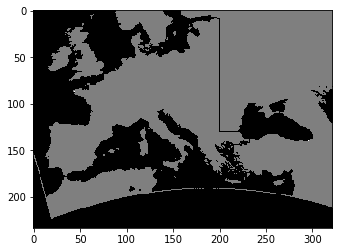

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(vld_img_grid_arr,'gray')
plt.show()

In [7]:
elv_vals = []
pop_vals = []

for i in range(256):
    # in meters avg
    if i==0: elv_vals.append(0)
    elif i<52: elv_vals.append(round(i*1000/51))
    elif i<64: elv_vals.append(round((i-51)*3800/(64-52) + 1000))
    
    if i<24: pop_vals.append(0)
    else: pop_vals.append(round((i-23)*3000/(255-23)))

In [8]:
max_age = 15

In [9]:
cell_ = {
    'i': None,
    'j': None,
    'elev': None, 
    'hum': 0, 
    'valid': None,
    'z_1': [0] * max_age, 
    'z_0': [0] * max_age 
}

def initializeCell():
    return copy.deepcopy(cell_)

In [10]:
# Determine the killed humans and update its cell value
def zombiesKillHumans(cell, layer):
    h = cell['hum']
    z = sum(cell['z_' + str(int(layer))])
    killed_h = 10 * z 
    remaining_h = h - killed_h if h > killed_h else 0
    cell['hum'] = remaining_h # kill humans 
    cell['z_' + str(int(layer))][0] = h - remaining_h # add them to new zombies
    return remaining_h

In [11]:
# Determine the killed zombies and update its cell value
def humanKillZombies(cell, layer):
    h = cell['hum']
    z = sum(cell['z_' + str(int(layer))])
    killed_z = 10 * h
    # assign randomly to the list the killings
    for k in range(killed_z):
        remaining_ages = [a for a in range(max_age) if cell['z_' + str(int(layer))][a] > 0]
        index = 0
        if len(remaining_ages) == 0:
            break
        elif len(remaining_ages) > 1:
            index = random.randint(0, len(remaining_ages) - 1)
        age = remaining_ages[index]
        cell['z_' + str(int(layer))][age] -= 1 
    return sum(cell['z_' + str(int(layer))]) # get remaining zombies

In [12]:
# "consider cells of 15 × 15 pixels" AND "1 pixel = 1 km 2"
len_cell = 15000 #m
len_diag = math.sqrt(pow(len_cell, 2) * 2) #m
dist_lin = len_cell
dist_dia = len_diag

def getGeoSlope(cell, to_cell):
    dist = dist_lin if (cell['i'] == to_cell['i'] or cell['j'] == to_cell['j']) else dist_dia
    diff = to_cell['elev'] - cell['elev']
    return math.degrees(math.atan2(diff, dist))

def getGeoSlopeFactor(cell, to_cell):
    slope = getGeoSlope(cell, to_cell)
    if slope < 0: 
        return 1 # zombies don't have any issue
    elif slope > 10:
        return 0 # zombies don't climb
    else: # then, between 0 and 10
        return 1 - (slope / 10) # zombies have certain difficulties

In [13]:
def zombiesMove(cell, neighbor_cells_list, layer):
    """ 
    1) thinking that the zombies will all go even if there are still humans
    2) We're assuming, also, that not all zombies should be moved (ex: slope constraint would encourage some to stay)
    """
    
    # today
    neighbor_humans = remaining_c = []
    for c in range(len(neighbor_cells_list)): # 8 cells max
        neighbor_humans.append(neighbor_cells_list[c]['hum'])
    h_neigh = sum(neighbor_humans)
    elev_c0 = cell['elev'] 

    # tomorrow
    autoDestroyZombies(cell, layer) # prepare zombies list for "tomorrow"
    z_c0 = sum(cell['z_' + str(int(layer))]) # zombies able to attack are just survivals aged < 15 
    #print(f'z-co: {z_c0}')
    remaining_c = [i for i in range(len(neighbor_cells_list))]
    random.shuffle(remaining_c)
    for c in range(len(neighbor_cells_list)): # 8 cells max
        #ran = random.randint(0, len(remaining_c) - 1) if len(remaining_c) > 0 else 0
        c_rand = remaining_c[-1]
        h = neighbor_cells_list[c_rand]['hum']
        geo_slope_fact = getGeoSlopeFactor(cell, neighbor_cells_list[c_rand]) # (from, to)
        z_new = getZombiesContribution(neighbor_cells_list[c_rand], h_neigh, z_c0, geo_slope_fact)
        #if layer == True : print("second")
        #if z_new > 0: print(f'z_new: {z_new}, c: {c_rand}, neigh: {len(neighbor_cells_list)}, rem: {len(remaining_c)}{remaining_c}, slope: {round(geo_slope_fact, 2)}|{cell["elev"]}|{neighbor_cells_list[c_rand]["elev"]}')
        assignZombiesByAge(cell, neighbor_cells_list[c_rand], z_new, layer)
        remaining_c.pop()
    
    for a in range(max_age): # assign remaining to next layer and reinitialize old layer
        cell['z_' + str(int(not layer))][a] += cell['z_' + str(int(layer))][a] 
        cell['z_' + str(int(layer))][a] = 0

In [14]:
def getZombiesContribution(cell, h_neigh, z_c0, geo_slope_fact):
    h = cell['hum']
    #print(f'h cell: {h}, z_c0: {z_c0}, h_neigh: {h_neigh}')
    if h_neigh == 0:
        return 0
    elif h_neigh > 0:
        return math.ceil((h / h_neigh) * z_c0 * geo_slope_fact)
    else:
        print("Error in Zombies contribution: z < 0 ?")

In [15]:
def autoDestroyZombies(cell, layer):
    cell['z_' + str(int(layer))].pop() # remove old zombies (last place)
    cell['z_' + str(int(layer))].insert(0, 0) # insert space for eaten humans (first place)
    
def assignZombiesByAge(cell, new_cell, n, layer):
    for i in range(n):
        remaining_ages = [a for a in range(max_age) if cell['z_' + str(int(layer))][a] > 0]
        index = 0
        if len(remaining_ages) == 0:
            return
        elif len(remaining_ages) > 1:
            index = random.randint(0, len(remaining_ages) - 1)        
        age = remaining_ages[index]
        cell['z_' + str(int(layer))][age] -= 1
        new_cell['z_' + str(int(not layer))][age] += 1

In [16]:
def showMatrixVals(m, key, corner_i, corner_j, around):
    new_m = [[0 for r in range(around)] for c in range(around)]
    for r in range(around):
        for c in range(around):
            new_m[r][c] = m[corner_i + r][corner_j + c][key]
    return new_m

In [17]:
def getNeigborCellList(i, j, m):
    n = []
    for i_sub in range(3): # Rows
        for j_sub in range(3): # Cols
            if i_sub == 1 and j_sub == 1: continue 
            if isCellCandidateForMove(i, i_sub, j, j_sub, m): 
                try:
                    n.append(m[i + i_sub - 1][j + j_sub - 1])
                except:
                    print(f'cell[{i + i_sub - 1}][{j + j_sub - 1}]')
    return n

In [18]:
def isCellCandidateForMove(i, i_sub, j, j_sub, m):
    # i: Rows, j: Columns
    ip = i + i_sub - 1
    jp = j + j_sub - 1
    if ip < 0 or jp < 0 : return False
    i_len = len(m) # how many rows
    j_len = len(m[i]) # how many columns
    if ip >= i_len or jp >= j_len: return False
    #print(f'checking i|ip|i_len: {i},{ip},{i_len} , j|jp|j_len: {j},{jp},{j_len}')
    if (m[i + i_sub - 1][j + j_sub - 1]['valid'] == 0): return False
    # MODIFY TO DETECT BORDERS OR CELLS NOT DESIRED
    return True

In [19]:
def runOneMoreDay(m, layer):
    z = h = 0
    # STEP 1 (Zombies move)
    for lon in range(len(m)):
        for lat in range(len(m[lon])):
            neighbor_cells = getNeigborCellList(lon, lat, m)
            zombiesMove(m[lon][lat], neighbor_cells, layer)
    # STEP 2 (Zombies Kill)
    for lon in range(len(m)):
        for lat in range(len(m[lon])):
            h += zombiesKillHumans(m[lon][lat], not layer) # layer, from recently moved zombies
    # STEP 3 (Humans kill)
    for lon in range(len(m)):
        for lat in range(len(m[lon])):
            z += humanKillZombies(m[lon][lat], not layer) # layer, from recently moved zombies
    return {'z': z, 'h': h}

In [20]:
def initializeGrid(vld_grid, pop_grid, elv_grid, pop_vals, elv_vals):
    m = [[initializeCell() for i in range(len(arr))] for j, arr in enumerate(vld_grid)]
    for r, arr in enumerate(vld_grid):
        for c, val in enumerate(arr):
            cell = m[r][c]
            pop_index = pop_grid[r][c]
            elv_index = elv_grid[r][c]
            cell['elev'] = elv_vals[elv_index]
            cell['hum'] = pop_vals[pop_index]
            cell['valid'] = vld_grid[r][c]
            cell['i'] = r
            cell['j'] = c
    return m

In [21]:
def rgb_int2tuple(rgbint):
    return (rgbint // 256 // 256 % 256, rgbint // 256 % 256, rgbint % 256)

def printImageFromGrid(grid, n):
    RGB = [0,0,0]
    m = [[RGB for i in range(len(arr))] for j, arr in enumerate(grid)]
    for r, arr in enumerate(grid):
        for c, cell in enumerate(arr):
            p = int((normalize(cell['hum'], pop_vals[0], pop_vals[-1])) * 255)
            z = int((normalize(sum(cell['z_0'] + cell['z_1']), elv_vals[0], elv_vals[-1])) * 255)
            m[r][c] = [p, z, 0]
            #b, g, r = rgb_int2tuple()
    np_m = np.array(m)
    im = Image.fromarray(np.uint8(np_m))
    im.save('./out/' + str(n) + '.png')
    return np_m

In [22]:
def normalize(v, mx, mn):
    return (v - mn)/(mx - mn)

In [23]:
def initializeZombies(grid, r, c, z):
    grid[r][c]['hum'] = 0
    grid[r][c]['z_' + str(0)][0] = z

In [24]:
def showMatrixZ(m):
    new = [[] for i in range(len(m))]
    for r, row in enumerate(m):
        for arr in row:
            new[r].append(sum(arr))
    return new

In [25]:
def run(grid, d, i_c = None, j_c = None, t = None):
    layer = False
    if not (i_c == None or j_c == None or t == None):
        pp.pprint(showMatrixVals(grid, 'elev', i_c, j_c, t))
        pp.pprint(showMatrixVals(grid, 'hum', i_c, j_c, t))
        pp.pprint(showMatrixZ(showMatrixVals(grid, 'z_' + str(int(layer)), i_c, j_c, t)))
    
    for day in range(d):
        vals = runOneMoreDay(grid, layer)
        layer = not layer # change layer
        print(f' ------   D-{day+1} Z={vals["z"]} H={vals["h"]}   ------ ')
        if not (i_c == None or j_c == None or t == None):
            pp.pprint(showMatrixVals(grid, 'valid', i_c, j_c, t))
            pp.pprint(showMatrixVals(grid, 'elev', i_c, j_c, t))
            pp.pprint(showMatrixVals(grid, 'hum', i_c, j_c, t))
            pp.pprint(showMatrixZ(showMatrixVals(grid, 'z_' + str(int(layer)), i_c, j_c, t)))
        else:
            printImageFromGrid(grid, day)
        

In [26]:
grid = initializeGrid(vld_img_grid_arr, 
               pop_img_grid_arr,
               elv_img_grid_arr,
               pop_vals,
               elv_vals
              )
initializeZombies(grid, z_loc[0], z_loc[1], rize_p)
run(grid, 300)

 ------   D-1 Z=96792 H=20505639   ------ 
 ------   D-2 Z=99584 H=20502847   ------ 
 ------   D-3 Z=102714 H=20499717   ------ 
 ------   D-4 Z=106606 H=20495825   ------ 
 ------   D-5 Z=111766 H=20490665   ------ 
 ------   D-6 Z=119241 H=20483157   ------ 
 ------   D-7 Z=127411 H=20474987   ------ 
 ------   D-8 Z=137206 H=20465093   ------ 
 ------   D-9 Z=149413 H=20452886   ------ 
 ------   D-10 Z=162597 H=20438327   ------ 
 ------   D-11 Z=178182 H=20422698   ------ 
 ------   D-12 Z=192734 H=20408146   ------ 
 ------   D-13 Z=207520 H=20393360   ------ 
 ------   D-14 Z=220264 H=20380606   ------ 
 ------   D-15 Z=139680 H=20366394   ------ 
 ------   D-16 Z=150912 H=20353140   ------ 
 ------   D-17 Z=165314 H=20335374   ------ 
 ------   D-18 Z=177539 H=20319849   ------ 
 ------   D-19 Z=193451 H=20299090   ------ 
 ------   D-20 Z=218021 H=20268329   ------ 
 ------   D-21 Z=243204 H=20235536   ------ 
 ------   D-22 Z=278911 H=20191250   ------ 
 ------   D-23 Z=3172

 ------   D-183 Z=31925 H=15531376   ------ 
 ------   D-184 Z=30064 H=15531376   ------ 
 ------   D-185 Z=27867 H=15531376   ------ 
 ------   D-186 Z=24570 H=15531376   ------ 
 ------   D-187 Z=20704 H=15531376   ------ 
 ------   D-188 Z=18583 H=15531376   ------ 
 ------   D-189 Z=15583 H=15531376   ------ 
 ------   D-190 Z=12868 H=15531376   ------ 
 ------   D-191 Z=8653 H=15531376   ------ 
 ------   D-192 Z=6402 H=15531376   ------ 
 ------   D-193 Z=4190 H=15531376   ------ 
 ------   D-194 Z=2431 H=15531376   ------ 
 ------   D-195 Z=0 H=15531376   ------ 
 ------   D-196 Z=0 H=15531376   ------ 
 ------   D-197 Z=0 H=15531376   ------ 
 ------   D-198 Z=0 H=15531376   ------ 
 ------   D-199 Z=0 H=15531376   ------ 
 ------   D-200 Z=0 H=15531376   ------ 
 ------   D-201 Z=0 H=15531376   ------ 
 ------   D-202 Z=0 H=15531376   ------ 
 ------   D-203 Z=0 H=15531376   ------ 
 ------   D-204 Z=0 H=15531376   ------ 
 ------   D-205 Z=0 H=15531376   ------ 
 ------   D-2

In [27]:
grid = initializeGrid(vld_img_grid_arr, 
               pop_img_grid_arr,
               elv_img_grid_arr,
               pop_vals,
               elv_vals
              )
initializeZombies(grid, z_loc[0], z_loc[1], rize_p)
subgrid = [[grid[z_loc[0] - 2 + j][z_loc[1] - 2 + i] for i in range(5)] for j in range(5)]
run(subgrid, 4, 0, 0 ,5)

[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 20],
 [0, 0, 20, 78, 157],
 [39, 78, 137, 216, 255],
 [196, 176, 255, 392, 804]]
[[0, 0, 0, 0, 65],
 [0, 0, 0, 362, 763],
 [13, 815, 0, 530, 297],
 [543, 1022, 362, 78, 297],
 [129, 284, 181, 78, 220]]
[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 94800, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]]
 ------   D-1 Z=96792 H=4047   ------ 
[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 127],
 [0, 0, 255, 127, 127],
 [127, 127, 127, 127, 127],
 [127, 127, 127, 127, 127]]
[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 20],
 [0, 0, 20, 78, 157],
 [39, 78, 137, 216, 255],
 [196, 176, 255, 392, 804]]
[[0, 0, 0, 0, 65],
 [0, 0, 0, 362, 763],
 [13, 815, 0, 0, 297],
 [543, 0, 0, 0, 297],
 [129, 284, 181, 78, 220]]
[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 2285, 25195, 0],
 [0, 48898, 16820, 3594, 0],
 [0, 0, 0, 0, 0]]
 ------   D-2 Z=99584 H=1255   ------ 
[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 127],
 [0, 0, 255, 127, 127],
 [127, 127, 127, 127, 127],
 [127, 127, 127, 127, 127]]
[[0, 0, 0, 0, 0],
 [0, 0

In [28]:
pp.pprint(showMatrixVals(subgrid, 'valid', 0, 0, 5))
pp.pprint(showMatrixVals(subgrid, 'hum', 0, 0, 5))

c1 = grid[z_loc[0]][z_loc[1]]
c2 = grid[z_loc[0] - 1][z_loc[1] - 1]
g = getGeoSlope(c1, c2)

g2 = getGeoSlopeFactor(c1, c2)
print(f'g{g}, g2{g2}')

[[0, 0, 0, 0, 0],
 [0, 0, 0, 0, 127],
 [0, 0, 255, 127, 127],
 [127, 127, 127, 127, 127],
 [127, 127, 127, 127, 127]]
[[0, 0, 0, 0, 65],
 [0, 0, 0, 362, 0],
 [13, 815, 0, 0, 0],
 [0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0]]
g-0.054018962963811507, g21


In [29]:
diff = 216 - 20
print(dist_dia)
print(math.atan2(diff, dist_dia))
print(math.degrees(math.atan2(diff, dist_dia)))
1 - (math.degrees(math.atan2(diff, dist_dia)) / 10)

21213.203435596424
0.009239265698206961
0.5293709303072507


0.947062906969275